In [35]:
# pip install mlxtend

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import learning_curve

# Model
# --------------------------------------------------------------------
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import metrics

# Importar datos Puros Tratados

In [37]:
data = pd.read_csv('./dataA.csv')
data.head(4)

,Netflows,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,Avg_pps,...,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine
0,-0.084787,-0.685410,-0.244709,-0.196223,0.361252,-0.132463,-0.625504,-0.317443,-0.359303,-0.336093,...,-0.343648,-0.398552,-0.417145,-0.476095,-0.558694,0,0,1,0,0
1,0.097929,-0.396662,-0.458780,-0.451115,0.409764,-0.352407,-0.625504,-0.309740,-0.359148,-0.308138,...,-0.372665,-0.423315,-0.417145,-0.482557,-0.565459,0,0,1,0,0
2,-0.022141,-0.632190,-0.074370,-0.007831,0.791878,0.572379,-0.625504,0.899656,0.216184,0.446664,...,-0.358157,-0.313647,-0.410669,-0.473671,-0.423312,0,0,1,0,0
3,-0.502423,2.149904,2.128327,2.109300,-0.351008,2.077954,2.160192,-0.369684,-0.364646,-0.392005,...,-0.169549,-0.239356,-0.221081,-0.274899,-0.355679,0,0,1,0,1


# Modelo

### Holdout

In [64]:
y = data['Type_mine']
X = data.drop('Type_mine',axis = 1)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, test_size=0.3, random_state = 123)

### KNN

In [40]:
k_vec = np.arange(1,40,2)
vec_train = []
vec_test =[]

for k in k_vec:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    vec_train.append(metrics.accuracy_score(y_train, y_pred))
    y_pred = knn.predict(X_test)
    vec_test.append(metrics.accuracy_score(y_test, y_pred))
v = pd.DataFrame()
v['K'] = k_vec
v['vec_train'] = vec_train
v['vec_test'] = vec_test
display(v)

,K,vec_train,vec_test
0,1,1.000000,0.997887
1,3,0.996680,0.995775
2,5,0.994869,0.996479
3,7,0.993359,0.993662
4,9,0.992756,0.990845
5,11,0.992152,0.990845
6,13,0.991850,0.990845
7,15,0.989134,0.990141
8,17,0.989134,0.990141
9,19,0.988832,0.989437


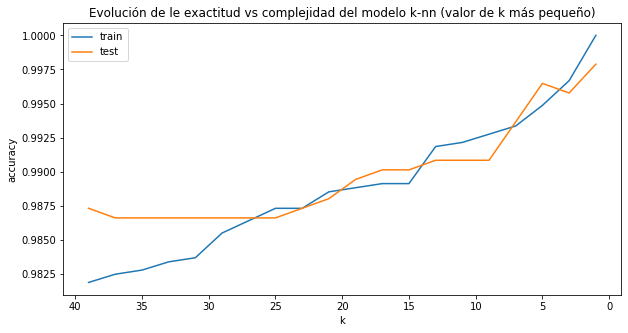

In [41]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.plot(k_vec, vec_train)
plt.plot(k_vec, vec_test)
ax.set_xlim(ax.get_xlim()[::-1])
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Evolución de le exactitud vs complejidad del modelo k-nn (valor de k más pequeño)')
plt.legend(['train', 'test'])

In [42]:
k_best = 8

In [43]:
knn = KNeighborsClassifier(n_neighbors=k_best)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')

In [44]:
y_pred = knn.predict(X_test)
y_pred

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

### Evaluación del modelo

In [45]:
y_test.shape, y_pred.shape

((1420,), (1420,))

([<matplotlib.axis.YTick at 0x2cb7a14c898>,
 <a list of 2 Text yticklabel objects>)

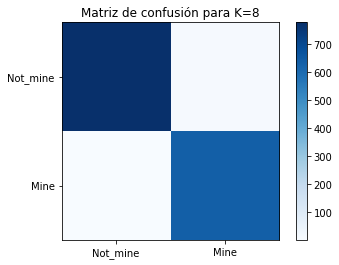

In [46]:
churm = metrics.confusion_matrix(y_test, y_pred)
plt.imshow(churm, cmap=plt.cm.Blues)
plt.title(f"Matriz de confusión para K={k_best}")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not_mine','Mine'])
plt.yticks(tick_marks, ['Not_mine','Mine'])

In [47]:
pd.DataFrame(churm)

,0,1
0,776,8
1,1,635


In [48]:
print("El modelo de KNN se equivocó en %d de los %d registros que componen el dataset original"
      % ((y_test != y_pred).sum(), data.shape[0]))

El modelo de KNN se equivocó en 9 de los 4733 registros que componen el dataset original


In [49]:
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa: ", metrics.cohen_kappa_score(y_test, y_pred))

Exactitud:  0.9936619718309859
Kappa:  0.9871980318226076


In [50]:
print(colored('Metricas de los registros mineros', attrs=['bold']))
print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=[1], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=[1], average='macro'))

VN = churm[0,0]
FP = churm[0,1]
specificity = VN/(VN+FP)


print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=[1], average='macro'))


Metricas de los registros mineros
Precisión     :  0.9875583203732504
Recall        :  0.9984276729559748
Especificidad :  0.9897959183673469
F1-score      :  0.9929632525410477


In [51]:
print(colored('Metricas de los registros no mineros', attrs=['bold']))
print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=[0], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=[0], average='macro'))

VN = churm[1,1]
FP = churm[1,0]
specificity = VN/(VN+FP)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=[0], average='macro'))

Metricas de los registros no mineros
Precisión     :  0.9987129987129987
Recall        :  0.9897959183673469
Especificidad :  0.9984276729559748
F1-score      :  0.9942344650864829


In [52]:
mse, bias, var =  bias_variance_decomp(knn, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), loss='mse', num_rounds=200)

In [53]:
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.007
Bias: 0.005
Variance: 0.002


In [54]:
train_sizes, train_scores, test_scores = learning_curve(KNeighborsClassifier(n_neighbors=8), 
                                                        X, y,cv=10,scoring='accuracy')

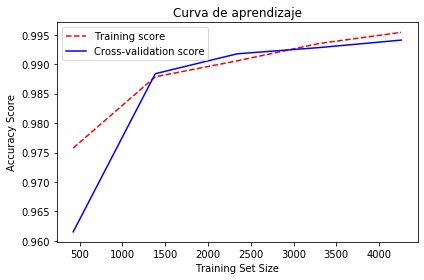

In [55]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, '--', color="red",  label="Training score")
plt.plot(train_sizes, test_mean, color="blue", label="Cross-validation score")

#plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="gray")
#plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="gray")

plt.title("Curva de aprendizaje")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Curva ROC

In [56]:
y_pred_proba = knn.predict_proba(X_test)

In [57]:
lr_probs = y_pred_proba[:,1]

In [58]:
ns_probs = [0 for _ in range(len(y_test))]

In [59]:
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
ns_auc

0.5

In [60]:
lr_auc = metrics.roc_auc_score(y_test, lr_probs)
lr_auc

0.9980215553202414

In [61]:
#Sumo los scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('KNN: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
KNN: ROC AUC=0.998


In [62]:
ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)

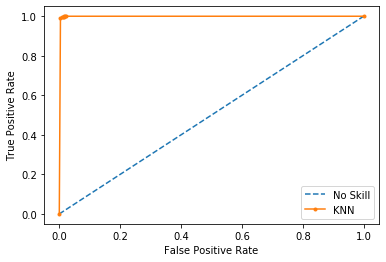

In [63]:
#Plot la roc curva para el modelo
plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()